In [2]:
%run "ZeroMQ Python Connector".py
%load_ext autoreload
%autoreload
%matplotlib notebook
import pandas as pd
from functools import partial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#Create connector instance, with particular port for PUSH, PULL and SUB
connector = DWX_ZeroMQ_Connector()

[INIT] Ready to send commands to METATRADER (PUSH): 32768
[INIT] Listening for responses from METATRADER (PULL): 32769
[INIT] Listening for market data from METATRADER (SUB): 32770


In [4]:
ID = connector._DWX_MTX_SEND_RATESDATA_REQUEST_(_symbol='GBPUSD', _start=(Timestamp.now()-Timedelta(days=100)).strftime('%Y.%m.%d %H:%M:00'),_timeframe=1440,_end=Timestamp.now().strftime('%Y.%m.%d %H:%M:00'))
response = connector._get_response_(messageID = ID)
print("\n This is the response: ", response)

{'_messageID': 911220764, '_action': 'DATA', '_data': {'2019.02.18 00:00': [1.29041, 1.29387, 1.28916, 1.29223, 114717, 0, 0], '2019.02.19 00:00': [1.29176, 1.3073, 1.28956, 1.30609, 120573, 0, 0], '2019.02.20 00:00': [1.30602, 1.3109, 1.30117, 1.30488, 126974, 0, 0], '2019.02.21 00:00': [1.30461, 1.30951, 1.3026, 1.30371, 135619, 0, 0], '2019.02.22 00:00': [1.30248, 1.308, 1.29679, 1.3054, 127336, 0, 0], '2019.02.25 00:00': [1.30499, 1.31144, 1.30497, 1.30951, 125833, 0, 0], '2019.02.26 00:00': [1.31167, 1.32879, 1.31141, 1.32491, 160731, 0, 0], '2019.02.27 00:00': [1.32513, 1.335, 1.32331, 1.33078, 152570, 0, 0], '2019.02.28 00:00': [1.33069, 1.33204, 1.32534, 1.32594, 135482, 0, 0], '2019.03.01 00:00': [1.32614, 1.32862, 1.31718, 1.32107, 136280, 0, 0], '2019.03.04 00:00': [1.32397, 1.32542, 1.31663, 1.31778, 141927, 0, 0], '2019.03.05 00:00': [1.31733, 1.31984, 1.30974, 1.31764, 144476, 0, 0], '2019.03.06 00:00': [1.31737, 1.31813, 1.31239, 1.31689, 132293, 0, 0], '2019.03.07 00:00

In [ ]:
response = Series(connector._get_response_())
responseData = Series(response["_data"])
print(type(responseData[0]))
order = connector._generate_default_order_dict()
print(order)

In [ ]:
order = connector._generate_default_order_dict()
connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol='GBPUSD', _start=(Timestamp.now()-Timedelta(minutes=1)).strftime('%Y.%m.%d %H:%M:00'),_timeframe=1,_end=Timestamp.now().strftime('%Y.%m.%d %H:%M:00'))
response = Series(connector._get_response_())
responseData = Series(response["_data"])
order['_symbol'] = 'GBPUSD'
order['_price'] = responseData[0]
#connector._DWX_MTX_NEW_TRADE_(order)

In [ ]:
message = connector._DWX_MTX_GET_ALL_OPEN_TRADES_()
print(message)

In [ ]:
def obtainMarketDataChunk(symbol,startTime, endTime, timeframe=1, data='DATA', chunkSize = 125):
    outputFrame = pd.DataFrame()
    chunkTime = timeframe * chunkSize 
    
    pdStartTime = Timestamp.strptime(startTime,'%Y.%m.%d %H:%M:00')
    pdEndTime = Timestamp.strptime(endTime,'%Y.%m.%d %H:%M:00')
    timeDelta = pdEndTime - pdStartTime 
    divMod = divmod(timeDelta,Timedelta(minutes=chunkTime))
    currentStartTime = None
    currentEndTime = None
    response = None
    print(divMod)
    
    for x in range(divMod[0]):
        print("--------------------------------------------------------------------------------------------------")
        oldResponse = connector._get_response_()
        currentStartTime = pdStartTime + (x*Timedelta(minutes=(chunkTime)))
        currentEndTime = pdStartTime + (x+1)*Timedelta(minutes=(chunkTime))
        ID = connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol=symbol, _start=currentStartTime.strftime('%Y.%m.%d %H:%M:00'),
                                                    _timeframe=timeframe,_end=currentEndTime.strftime('%Y.%m.%d %H:%M:00'))
        
        response = connector._get_response_(messageID = ID)
        outputFrame = outputFrame.append(Series(response['_data']).to_frame()) # Append to dataframe
        sleep(0.1) # To prevent resource timeout
        print("--------------------------------------------------------------------------------------------------")
        
    
    print("--------------------------------------------------------------------------------------------------")
    ID = connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol=symbol, _start=currentEndTime.strftime('%Y.%m.%d %H:%M:00'),
                                                _timeframe=timeframe,_end=endTime)

    response = connector._get_response_(messageID = ID)
    outputFrame = outputFrame.append(Series(response['_data']).to_frame())
    outputFrame = outputFrame.reset_index()
    outputFrame.rename(columns={'index':'Date', 0:'ClosePrice'}, inplace=True)
    outputFrame['Date'] = pd.to_datetime(outputFrame['Date'], format='%Y.%m.%d %H:%M')
    outputFrame = outputFrame.set_index('Date')
    print("--------------------------------------------------------------------------------------------------")
    return outputFrame


In [ ]:
datachunk = obtainMarketDataChunk('GBPUSD', '2017.05.23 10:00:00', '2019.05.23 01:00:00',timeframe=1440)
print(datachunk.to_string())

In [ ]:
datachunk.plot()

In [17]:
def obtainMarketDataChunk(symbol,startTime, endTime, timeframe=1, data='DATA', chunkSize = 125):
    
    ## Required Variables 
    outputFrame = pd.DataFrame()
    chunkTime = timeframe * chunkSize 
    pdStartTime = Timestamp.strptime(startTime,'%Y.%m.%d %H:%M:00')
    pdEndTime = Timestamp.strptime(endTime,'%Y.%m.%d %H:%M:00')
    timeDelta = pdEndTime - pdStartTime 
    divMod = divmod(timeDelta,Timedelta(minutes=chunkTime))
    currentStartTime = pdStartTime
    currentEndTime = pdEndTime
    response = None
    if data == 'RATESDATA':
        requestDataFunction = partial(connector._DWX_MTX_SEND_RATESDATA_REQUEST_,_symbol=symbol, _timeframe=timeframe)
    elif data == 'DATA':
        requestDataFunction = partial(connector._DWX_MTX_SEND_MARKETDATA_REQUEST_,_symbol=symbol, _timeframe=timeframe)
    print(divMod)
    
    for x in range(divMod[0]):
        print("--------------------------------------------------------------------------------------------------")
        oldResponse = connector._get_response_()
        currentEndTime = pdStartTime + (x+1)*Timedelta(minutes=(chunkTime))
        print(currentStartTime.strftime('%Y.%m.%d %H:%M:00'))
        print(currentEndTime.strftime('%Y.%m.%d %H:%M:00'))
        ID = requestDataFunction(_start=currentStartTime.strftime('%Y.%m.%d %H:%M:00')
                                 ,_end=currentEndTime.strftime('%Y.%m.%d %H:%M:00'))
        
        response = connector._get_response_(messageID = ID, maximumTime=8)
        outputFrame = outputFrame.append(pd.DataFrame.from_dict(response['_data'],orient='index')) # Append to dataframe
        currentStartTime = currentEndTime
        sleep(0.1) # To prevent resource timeout
        print("--------------------------------------------------------------------------------------------------")
        
    
    print("--------------------------------------------------------------------------------------------------")
    ID = requestDataFunction(_start=currentStartTime.strftime('%Y.%m.%d %H:%M:00'),_end=endTime)
    print(currentStartTime.strftime('%Y.%m.%d %H:%M:00'))
    print(endTime)
    response = connector._get_response_(messageID = ID, maximumTime = 8)
    outputFrame = outputFrame.append(pd.DataFrame.from_dict(response['_data'],orient='index'))
    outputFrame = outputFrame.reset_index()
    if data == 'DATA':
        outputFrame.rename(columns={'index':'Date', 0:'Close'}, inplace=True)
    elif data == 'RATESDATA':
        outputFrame.rename(columns={'index':'Date', 0:'Open', 1:'High', 2:'Low', 3:'Close', 4:'TickVol', 5:'Spread', 6:'RealVol'}, inplace=True)
    outputFrame['Date'] = pd.to_datetime(outputFrame['Date'], format='%Y.%m.%d %H:%M')
    outputFrame = outputFrame.set_index('Date')
    print("--------------------------------------------------------------------------------------------------")
    return outputFrame


In [35]:
datachunk = obtainMarketDataChunk('GBPUSD', '2018.05.23 02:00:00', '2019.05.24 02:00:00',timeframe=1440, data='RATESDATA')
print(datachunk.to_string())

(2, Timedelta('116 days 00:00:00'))
--------------------------------------------------------------------------------------------------
2018.05.23 02:00:00
2018.09.25 02:00:00
{'_messageID': 1976111627, '_action': 'DATA', '_data': {'2018.05.24 00:00': [1.33346, 1.34216, 1.33346, 1.33779, 185946, 0, 0], '2018.05.25 00:00': [1.3377, 1.33874, 1.32936, 1.33008, 180009, 0, 0], '2018.05.28 00:00': [1.33129, 1.33408, 1.32963, 1.33083, 143494, 0, 0], '2018.05.29 00:00': [1.33059, 1.33252, 1.32042, 1.32447, 222672, 0, 0], '2018.05.30 00:00': [1.32444, 1.3307, 1.3235, 1.32815, 207960, 0, 0], '2018.05.31 00:00': [1.32832, 1.33481, 1.32771, 1.32955, 188238, 0, 0], '2018.06.01 00:00': [1.32937, 1.33619, 1.32534, 1.33506, 185859, 0, 0], '2018.06.04 00:00': [1.33351, 1.33984, 1.32948, 1.33135, 153169, 0, 0], '2018.06.05 00:00': [1.33127, 1.34086, 1.3302, 1.33836, 159027, 0, 0], '2018.06.06 00:00': [1.33779, 1.34434, 1.33762, 1.34106, 152310, 0, 0], '2018.06.07 00:00': [1.34094, 1.34721, 1.33717, 1.342

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
2019.01.28 02:00:00
2019.05.24 02:00:00
{'_messageID': 979682135, '_action': 'DATA', '_data': {'2019.01.29 00:00': [1.31536, 1.31996, 1.30562, 1.30661, 181087, 0, 0], '2019.01.30 00:00': [1.30625, 1.31457, 1.30541, 1.31139, 156784, 0, 0], '2019.01.31 00:00': [1.31041, 1.31602, 1.30975, 1.31092, 144379, 0, 0], '2019.02.01 00:00': [1.31008, 1.31149, 1.30432, 1.30769, 135728, 0, 0], '2019.02.04 00:00': [1.307, 1.31034, 1.3029, 1.30299, 117102, 0, 0], '2019.02.05 00:00': [1.30359, 1.30517, 1.29247, 1.29489, 118639, 0, 0], '2019.02.06 00:00': [1.29436, 1.29791, 1.29251, 1.29286, 120138, 0, 0], '2019.02.07 00:00': [1.29288, 1.29963, 1.28539, 1.29483, 127750, 0, 0], '2019.02.08 00:00': [1.29469, 1.29759, 1.29211, 1.29404, 103369, 0, 0], '2019.02.11 00:00': [1.29277, 1.2939, 1.28449, 1.28592, 115630

In [54]:
datachunk.loc[:,'Open':'Close']

,Open,High,Low,Close
Date,,,,
2018-05-24,1.33346,1.34216,1.33346,1.33779
2018-05-25,1.33770,1.33874,1.32936,1.33008
2018-05-28,1.33129,1.33408,1.32963,1.33083
2018-05-29,1.33059,1.33252,1.32042,1.32447
2018-05-30,1.32444,1.33070,1.32350,1.32815
2018-05-31,1.32832,1.33481,1.32771,1.32955
2018-06-01,1.32937,1.33619,1.32534,1.33506
2018-06-04,1.33351,1.33984,1.32948,1.33135
2018-06-05,1.33127,1.34086,1.33020,1.33836


<IPython.core.display.Javascript object>


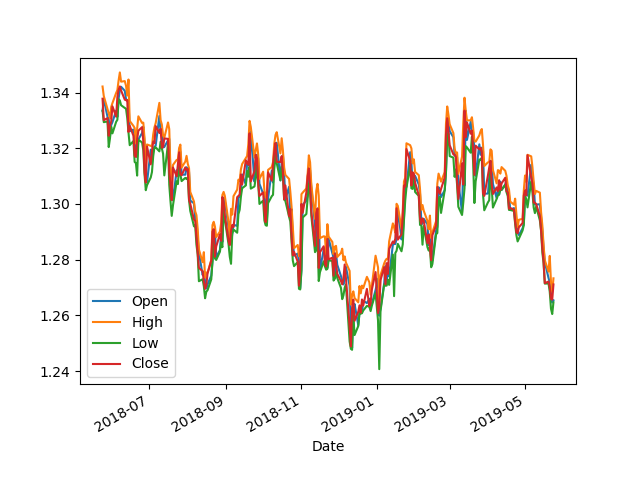

In [55]:
datachunk.loc[:,'Open':'Close'].plot()